Для любых пар изображений которые имеют общее поле зрения (две фотографии сделанные с телефона который был повернут на определенный угол - любой лишь бы было 20+% перекрытия)
Рассчитать матрицу афинного преобразования из одной системы координат в другую. Выполнить разложение данной матрицы и посчитать явно угол поворота, вектор переноса и скалирования. 
Выполнить обратное преобразование - получить афинную матрицу заново. 

In [1]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

Matplotlib is building the font cache; this may take a moment.


In [2]:
def extract_features(image, detector='sift', mask=None):

    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
    elif detector == 'surf':
        det = cv2.xfeatures2d.SURF_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [3]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'
    detector -- (str) can be 'sift or 'orb'. Default is 'sift'
    sort -- (bool) whether to sort matches by distance. Default is True
    k -- (int) number of neighbors to match to each feature.

    Returns:
    matches -- list of matched features from two images. Each match[i] is k or less matches for 
               the same query descriptor
    """
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [4]:
def filter_matches_distance(matches, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

In [7]:
img0 = cv2.imread("photo_1.jpg")
img1 = cv2.imread("photo_2.jpg")

In [8]:
blurred = cv2.GaussianBlur(img0, (11,11),0)
img0 = cv2.addWeighted(img0, 2, blurred, -1, 0)    
blurred = cv2.GaussianBlur(img1, (11,11),0)
img1 = cv2.addWeighted(img1, 2, blurred, -1, 0)

In [9]:
def processing_max_dim(frame_resize, processing_max_dim): 
    #Функция которая уменьшает размер для ускорения оптического потока

    
    height = frame_resize.shape[0]
    width = frame_resize.shape[1]
    max_dim_size = max(height, width);
    cof = 0
    if (max_dim_size > processing_max_dim):

        if (height > width):
            width_s = width * (processing_max_dim/ height);
            cof = processing_max_dim/ height
            frame_resize = cv2.resize(frame_resize, (int(width_s), int(processing_max_dim)));
        
        else:
        
            height_s = height * (processing_max_dim / width);
            cof = processing_max_dim / width
            
            frame_resize = cv2.resize(frame_resize, (int(processing_max_dim), int(height_s)));

    return frame_resize, cof 

In [10]:
img0, cof = processing_max_dim(img0,450)
img1, cof = processing_max_dim(img1,450)

In [11]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)
    # Убираем оси
    plt.axis('off')

    # Сохраняем график в файл
    plt.savefig('plot_without_axes.png', bbox_inches='tight', pad_inches=0)

Number of matches before filtering: 249
Number of matches after filtering: 5


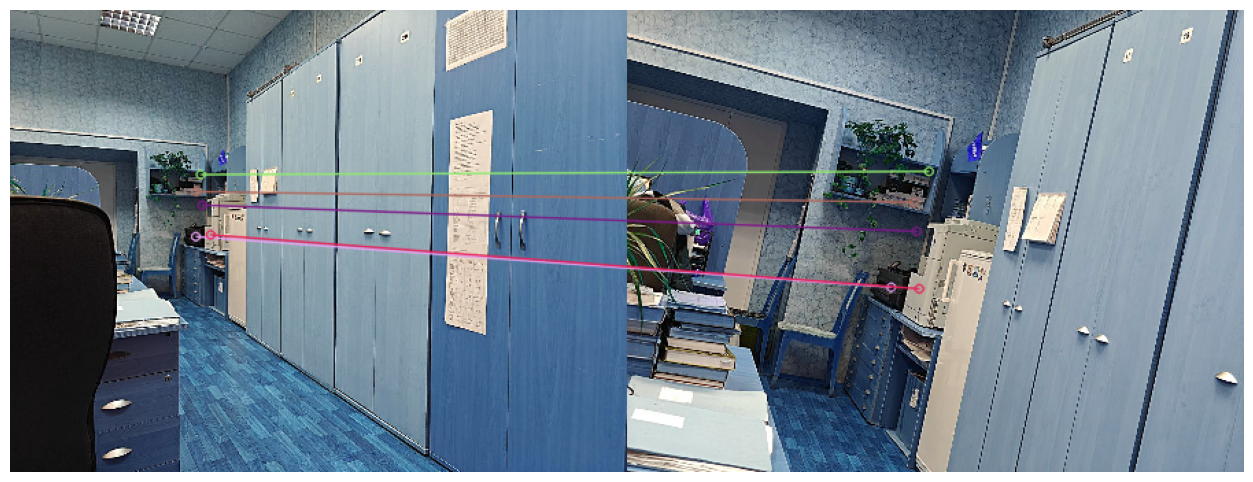

In [12]:
kp0, des0 = extract_features(img0, 'sift')
kp1, des1 = extract_features(img1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.345)
print('Number of matches after filtering:', len(matches))
visualize_matches(img0, kp0, img1, kp1, matches)